In [1]:
import numpy as np
import torch
from diffusionmodel import *
from torch.optim import Adam
import bgflow.distribution.sampling.mcmc as MCMC
import bgflow.distribution.energy.double_well as DoubleWell
import bgflow.distribution.normal as Normal
import matplotlib.pyplot as plt


torch.random.manual_seed(199)

device = 'cuda'
T = 200


In [2]:
target = DoubleWell.DoubleWellEnergy(dim=1, b=-4., c=1.)
prior = Normal.NormalDistribution(dim=1)

net = torch.nn.Sequential(torch.nn.Linear(2, 64), torch.nn.SiLU(), torch.nn.Linear(64, 64),  torch.nn.SiLU(), torch.nn.Linear(64, 1))


ts = torch.linspace(0, T, 50)
xs = torch.linspace(-3, 3, 50)

X, Y = torch.meshgrid(xs, ts)

/srv/public/maaig92/miniconda3/envs/nequip/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


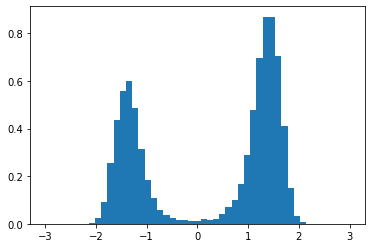

In [3]:
sampler = MCMC.GaussianMCMCSampler(energy=target, init_state=torch.tensor([0.]))

from utils import load_or_generate_and_then_save
datafilepath = 'double_well.npy'
data = torch.from_numpy(load_or_generate_and_then_save(datafilepath, lambda : sampler.sample(n_samples=50000)))

# plot histogram of the sampled data
counts, bins = np.histogram(data, bins=xs, density=True)
# plt.plot(bins, torch.exp(-target.energy(torch.tensor(bins).unsqueeze_(1))))
plt.stairs(counts, bins, fill=True)
plt.show()

In [4]:
beta_schedule = torch.linspace(1e-4, 0.05, T)
diff_model = DiffusionModel(net=net, variance_schedule=beta_schedule, device=device)
print(sum([len(p) for p in diff_model.parameters()]))

322


/tmp/ipykernel_50544/243559533.py:8: UserWarning: The following kwargs were not used by contour: 'keepdim'
  im1=plt.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))


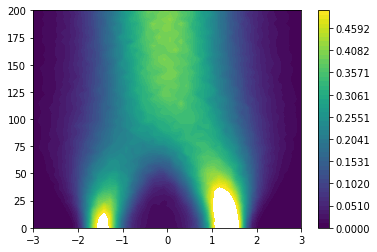

In [5]:
z = torch.zeros_like(X)
for i, t in enumerate(range(0, T, 4)):
    t_s=torch.full(data.shape, t).to(device)
    x_t = diff_model.apply_noise(x_0=data.to(device), t_s=t_s)[0]
    z[:, i] = torch.histogram(x_t.cpu(), bins=torch.cat([xs.cpu(), torch.tensor([6.])]), density=True)[0]


im1=plt.contourf(X.cpu(), Y.cpu(), z.cpu(), keepdim=True, levels=np.linspace(0, 0.5,50))
plt.colorbar(im1)

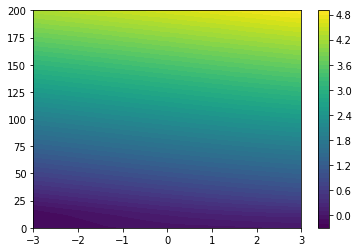

Epoch 0/30 total loss: 755.0946655273438691070674
Epoch 1/30 total loss: 666.4277343759094663262367
Epoch 2/30 total loss: 642.1119995117188242921065
Epoch 3/30 total loss: 529.2901000976562291260319
Epoch 4/30 total loss: 477.827697753906253916e-08


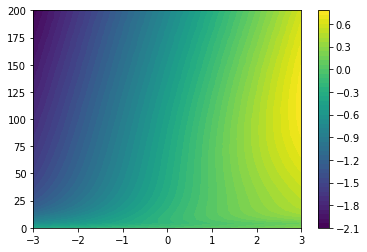

Epoch 5/30 total loss: 433.117736816406256135e-065
Epoch 6/30 total loss: 393.21905517578125248059856
Epoch 7/30 total loss: 389.4533081054687525508905
Epoch 8/30 total loss: 453.5727844238281576015478
Epoch 9/30 total loss: 404.4934387207031619524964


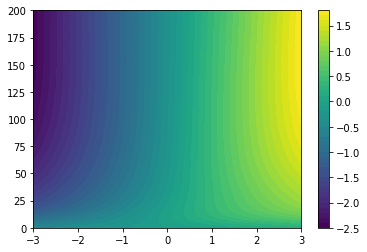

Epoch 10/30 total loss: 413.050903320312593784788
Epoch 11/30 total loss: 389.75747680664069503e-058
Epoch 12/30 total loss: 356.5578918457031750786455
Epoch 13/30 total loss: 393.3043823242187512756015
Epoch 14/30 total loss: 359.344879150390699229574


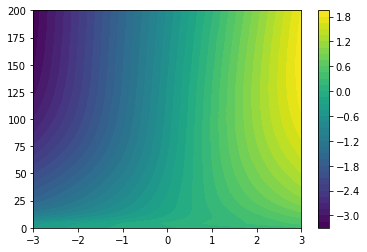

Epoch 15/30 total loss: 394.9330444335937591948055
Epoch 16/30 total loss: 343.0492248535156096033155
Epoch 17/30 total loss: 320.486511230468751342899
Epoch 18/30 total loss: 317.9891052246094525510505
Epoch 19/30 total loss: 361.632598876953143777577


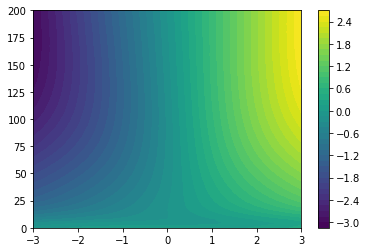

Epoch 20/30 total loss: 341.0119628906253773197754
Epoch 21/30 total loss: 360.2502441406258691336563
Epoch 22/30 total loss: 377.188690185546901921103
Epoch 23/30 total loss: 362.951202392578176631258
Epoch 24/30 total loss: 341.9536743164062512398505


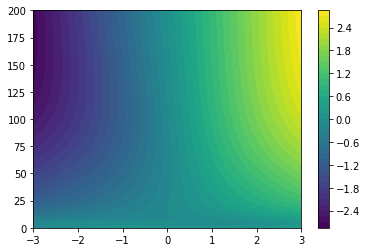

Epoch 25/30 total loss: 355.567596435546958072963
Epoch 26/30 total loss: 327.1748657226562566651755
Epoch 27/30 total loss: 324.0830688476562548931-06
Epoch 28/30 total loss: 339.914611816406256348495
Epoch 29/30 total loss: 334.8671264648437554838805


In [6]:
batch_size=64


#plot_sample_noising(diff_model, train_data, n_timesteps = 20, n_samples=3)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
optimizer = Adam(diff_model.parameters(), lr=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3, cooldown=3, verbose=True)

from train import train
def callback(model):
      model_energy = model(X.reshape(50*50, 1).cuda(), Y.reshape(50*50, 1).cuda()).view(50,50).detach()
   #   model_probability = to_normalized_probabilities(model_energy) 

      plt.contourf(X, Y, model_energy.cpu(), levels=50)
      plt.colorbar()
      plt.show()


train(diff_model, 
      loss_fn=torch.nn.MSELoss(), 
      optimizer=optimizer, 
      data_loader=train_loader, 
      scheduler=None, 
      n_iterations=30, 
      device=device, 
      callback_interval=5,
      callback=callback)


In [11]:
diff_model.sample([100])


KeyboardInterrupt

